In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/Users/qnl/Documents/Vinay/QNL')

from qnl_ctrl.qnl_analysis import SimTools as ST
from qnl_ctrl.qnl_analysis.SimTools import bit_to_trit, rot_x, rot_y, trit_z

from importlib import reload
from functools import reduce

In [2]:
qutrit_mapping = {'I': np.eye(3, dtype='complex'),                                                                                                                               
                  'GPrep': np.eye(3, dtype='complex'),
                  'X90': bit_to_trit(rot_x(np.pi/2.)),
                  'X-90': bit_to_trit(rot_x(-np.pi/2.)),
                  'Y90': bit_to_trit(rot_y(np.pi/2.)),
                  'Y-90': bit_to_trit(rot_y(-np.pi/2.)),
                  'X270': bit_to_trit(rot_x(-np.pi/2.)),
                  'Y270': bit_to_trit(rot_y(-np.pi/2.)),
                  'X180': bit_to_trit(rot_x(np.pi)),
                  'Y180': bit_to_trit(rot_y(np.pi)),
                  'EFX90': bit_to_trit(rot_x(np.pi/2.), 1),
                  'EFX-90': bit_to_trit(rot_x(-np.pi/2.), 1),
                  'EFY90': bit_to_trit(rot_y(np.pi/2.), 1),
                  'EFY-90': bit_to_trit(rot_y(-np.pi/2.), 1),
                  'EFX270': bit_to_trit(rot_x(-np.pi/2.), 1),
                  'EFY270': bit_to_trit(rot_y(-np.pi/2.), 1),
                  'EFX180': bit_to_trit(rot_x(np.pi), 1),
                  'EFY180': bit_to_trit(rot_y(np.pi), 1),
                  'Delay': np.eye(3, dtype='complex'),
                  'Hadamard': np.sqrt(1./3)*np.array([[1,1,1],
                                        [1,np.exp(1j*2*np.pi/3),np.exp(-1j*2*np.pi/3)],
                                        [1,np.exp(-1j*2*np.pi/3),np.exp(1j*2*np.pi/3)]]),
                  'R': np.diag([1, np.exp(1j*2*np.pi/3),np.exp(1j*2*np.pi/3)])                   }

In [3]:
def isfloat(value):                                                                                                                                                              
    try:
        float(value)
        return True
    except ValueError:
        return False

In [4]:
def Hadamard_to_identity(alpha):
    """ returns a single-qutrit unitary matrix which
    smoothly interpolates between the Hadamard gate and the identity gate
    When alpha is unity, it is the Hadamard
    When alpha is zero, it is the identity
    """
    
    Hadamard_pulse_sequence = [['EFY-90'],
    ['X90'],
    ['Z{:.5f}'.format(-109.471*alpha)],
    ['EFZ{:.5f}'.format(54.7355*alpha)],
    ['X-90'],
    ['Z{:.5f}'.format(180*alpha)],
    ['EFZ{:.5f}'.format(-90*alpha)],
    ['EFY90']]
    
    return resulting_unitary(Hadamard_pulse_sequence)

def HadamardStar_to_identity(alpha):
    """ returns a single-qutrit unitary matrix which
    smoothly interpolates between the Hadamard gate and the identity gate
    When alpha is unity, it is the Hadamard
    When alpha is zero, it is the identity
    """
    
    Hadamard_pulse_sequence = [['EFY-90'],
    ['X-90'],
    ['Z{:.5f}'.format(109.471*alpha)],
    ['EFZ{:.5f}'.format(-54.7355*alpha)],
    ['X90'],
    ['Z{:.5f}'.format(-180*alpha)],
    ['EFZ{:.5f}'.format(90*alpha)],
    ['EFY90']]
    
    return resulting_unitary(Hadamard_pulse_sequence)

def Scrambler_to_identity(alpha):
    
    alpha_Had = Hadamard_to_identity(alpha)
    alpha_Had_dag = np.conj(alpha_Had).T
    
    alpha_Had_2q = np.kron(alpha_Had, alpha_Had)
    alpha_Had_dag_2q = np.kron(alpha_Had_dag, alpha_Had_dag)

    gates = [alpha_Had_dag_2q, ST.qt_cmin_p1, alpha_Had_2q, ST.qt_csum_p1]
    
    return reduce(np.dot, gates)

def resulting_unitary(pulse_sequence):
    # starting from the initial state, calculates the unitary after the pulse_sequence is applied                                                                            
    # here time flows from left to right, in that the first pulse in the pulse_string is the first pulse applied.
    single_qutrit_unitary = np.eye(3)
    for x in pulse_sequence:
        pulse_string = x[0]
        if pulse_string in list(qutrit_mapping.keys()):
            single_qutrit_unitary = np.dot(qutrit_mapping[pulse_string], single_qutrit_unitary)
        else:
            if pulse_string[0] == 'Z':
                phase = np.pi*float(pulse_string[1:])/180.
                single_qutrit_unitary = np.dot(trit_z(phase,-1)[0], single_qutrit_unitary)

            elif pulse_string[0:3] == 'EFZ':
                phase = np.pi*float(pulse_string[3:])/180.
                single_qutrit_unitary = np.dot(trit_z(phase,1)[0], single_qutrit_unitary)
    return single_qutrit_unitary


In [7]:
alpha_range = np.linspace(0,1,50)
unitaries = [Scrambler_to_identity(alpha) for alpha in alpha_range]
OTOCs = np.array([np.real(ST.OTOC(Scrambler_to_identity(alpha), Qutrit_ops)) for alpha in alpha_range])

In [6]:
omega = np.exp(2*np.pi*1j/3)

X = np.matrix([[0,0,1],[1,0,0],[0,1,0]])
Z = np.matrix(np.diag([1, omega, omega*omega]))
Y = X*Z
V = X*Z*Z

Qutrit_ops = [
    np.matrix(np.eye(3), dtype = 'complex'),
    Z, 
    X, 
    Y, 
    V, 
    Z*Z,
    X*X,
    Y*Y,
    V*V,
]

In [11]:
np.round(unitaries[-1])

matrix([[ 1.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.-0.j,  0.+0.j,  0.-0.j,
          0.+0.j,  0.-0.j],
        [-0.-0.j,  0.+0.j,  0.+0.j,  0.-0.j, -0.+0.j,  0.-0.j, -0.-0.j,
          0.+0.j,  1.-0.j],
        [-0.-0.j,  0.-0.j,  0.-0.j, -0.-0.j,  1.-0.j,  0.+0.j,  0.-0.j,
          0.+0.j, -0.+0.j],
        [ 0.-0.j,  0.-0.j,  0.+0.j, -0.+0.j, -0.+0.j,  1.+0.j,  0.-0.j,
          0.+0.j, -0.+0.j],
        [ 0.+0.j,  1.+0.j, -0.-0.j, -0.+0.j,  0.+0.j, -0.-0.j, -0.+0.j,
         -0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j, -0.-0.j, -0.-0.j,  1.-0.j,
          0.+0.j, -0.-0.j],
        [ 0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j, -0.+0.j,  0.+0.j, -0.+0.j,
          1.+0.j, -0.+0.j],
        [ 0.-0.j,  0.+0.j, -0.+0.j,  1.+0.j, -0.-0.j,  0.+0.j,  0.+0.j,
         -0.-0.j, -0.-0.j],
        [ 0.+0.j, -0.-0.j,  1.+0.j, -0.+0.j, -0.-0.j, -0.-0.j, -0.+0.j,
         -0.-0.j,  0.-0.j]])

Text(0,0.5,'OTOC')

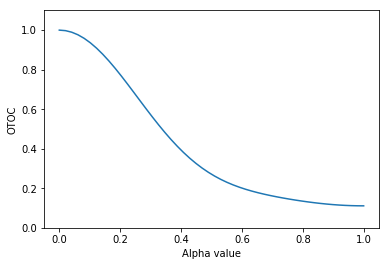

In [9]:
plt.plot(alpha_range, OTOCs)
plt.ylim(0,1.1)
plt.xlabel('Alpha value')
plt.ylabel('OTOC')